In [113]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannotations.Annotator as statannotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

# Appending python modules so we can run simulations
sys.path.append('../python')

import json_utilities
import model_utilities
from matplotlib.pyplot import figure
from pymunk.vec2d import Vec2d
from scipy import stats

In [114]:
# Are we saving figures?
saving_figures = False
figure_dir = '../paper/figures/src'

In [115]:
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=2,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
    },
)


In [116]:
df_exp2 = pd.read_json('../data/cleaned_data/cleaned_data_exp2.json')

In [85]:
# Directory with model fits
path_to_model_predictions = "../data/model_fits/model_fits_exp1.csv"
path_to_model_predictions = os.path.expanduser('~/Desktop/model_fits.csv')

In [86]:
# Dataframe with model fits
model_df = pd.read_csv(path_to_model_predictions)

In [87]:
# Sort model parameters based on MSE
best_fitting_parameters = model_df[model_df['mse'] >= max(model_df['mse'])]
best_fitting_parameters_exp1 = best_fitting_parameters
best_fitting_parameters

,N,D,E,Noise,mse
34787,5,75,0.9,0.0,8.17879


In [88]:
# Grab the best fitting parameters
n = list(best_fitting_parameters['N'])[0]
d = list(best_fitting_parameters['D'])[0]
e = list(best_fitting_parameters['E'])[0]
noise = list(best_fitting_parameters['Noise'])[0]
n,d,e, noise

(5, 75, 0.9, 0.0)

In [89]:
# Path to jsons of scenes
path_to_scene_dir_exp2 = "../data/json/experiment2"

In [90]:
# Gather JSON files of scenes from Experiment 2
scene_json_files_exp2 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp2) if pos_json.endswith('.json')]
distance_df = pd.DataFrame({})
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        {'view': False, 'noise': 0}
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    scene_distance_df = pd.DataFrame(
        {'scene':scene_name,
         'distance':df_simulation_model_sample['trajectory_length']
        }
    )
    distance_df = pd.concat([distance_df,scene_distance_df])

In [91]:
# Model results
# Blended model
model_blended_results_exp2 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp2 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp2 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': 0.001,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': 0.001,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.001,
}

In [92]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
        # Collect statistics from samples
        df_blended_result = pd.DataFrame(
            {'scene':scene_name,
             'collision_probability':np.mean(df_blended_model_output['collision']),
             'simulation_time':df_blended_model_output['simulation_ticks'],
             'distance':df_blended_model_output['trajectory_length'],
             'type':'blended_model'
            }
        )
    # Update results
    model_blended_results_exp2 = pd.concat([model_blended_results_exp2,df_blended_result])

In [93]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'distance':df_simulation_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp2 = pd.concat([model_simulation_results_exp2,df_simulation_result])

In [94]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'distance':df_abstraction_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp2 = pd.concat([model_abstraction_results_exp2,df_abstraction_result])

In [95]:
# blended_model_acc = model_blended_results_exp2.groupby('scene').collision_probability.mean().to_frame()
blended_model_acc = model_blended_results_exp2[['collision_probability', 'scene']]
blended_model_acc['model'] = 'blended'
blended_model_acc = blended_model_acc.rename(columns={'collision_probability': 'correct'})
blended_model_acc = blended_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_55123/3585766579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blended_model_acc['model'] = 'blended'


In [96]:
# simulation_model_acc = model_simulation_results_exp2.groupby('scene').collision_probability.mean().to_frame()
simulation_model_acc = model_simulation_results_exp2[['collision_probability', 'scene']]
simulation_model_acc['model'] = 'simulation'
simulation_model_acc = simulation_model_acc.rename(columns={'collision_probability': 'correct'})
simulation_model_acc = simulation_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_55123/2769324660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation_model_acc['model'] = 'simulation'


In [97]:
# abstraction_model_acc = model_abstraction_results_exp2.groupby('scene').collision_probability.mean().to_frame()
abstraction_model_acc = model_abstraction_results_exp2[['collision_probability', 'scene']]
abstraction_model_acc['model'] = 'abstraction'
abstraction_model_acc = abstraction_model_acc.rename(columns={'collision_probability': 'correct'})
abstraction_model_acc = abstraction_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_55123/2869950598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abstraction_model_acc['model'] = 'abstraction'


In [98]:
empirical_acc = df_exp2[['correct','scene']]
empirical_acc['model'] = 'empirical'

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_55123/735060496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empirical_acc['model'] = 'empirical'


In [99]:
accuracy_df = pd.concat([simulation_model_acc, empirical_acc, blended_model_acc, abstraction_model_acc])

In [100]:
accuracy_df = accuracy_df.reset_index(drop=True)

In [101]:
accuracy_df['goal_point_idx'] = accuracy_df.scene.apply(lambda x: x.split('_')[-1])
accuracy_df['scene_type'] = accuracy_df.scene.apply(lambda x: x.split('_')[1])
accuracy_df = accuracy_df.merge(distance_df, on='scene')

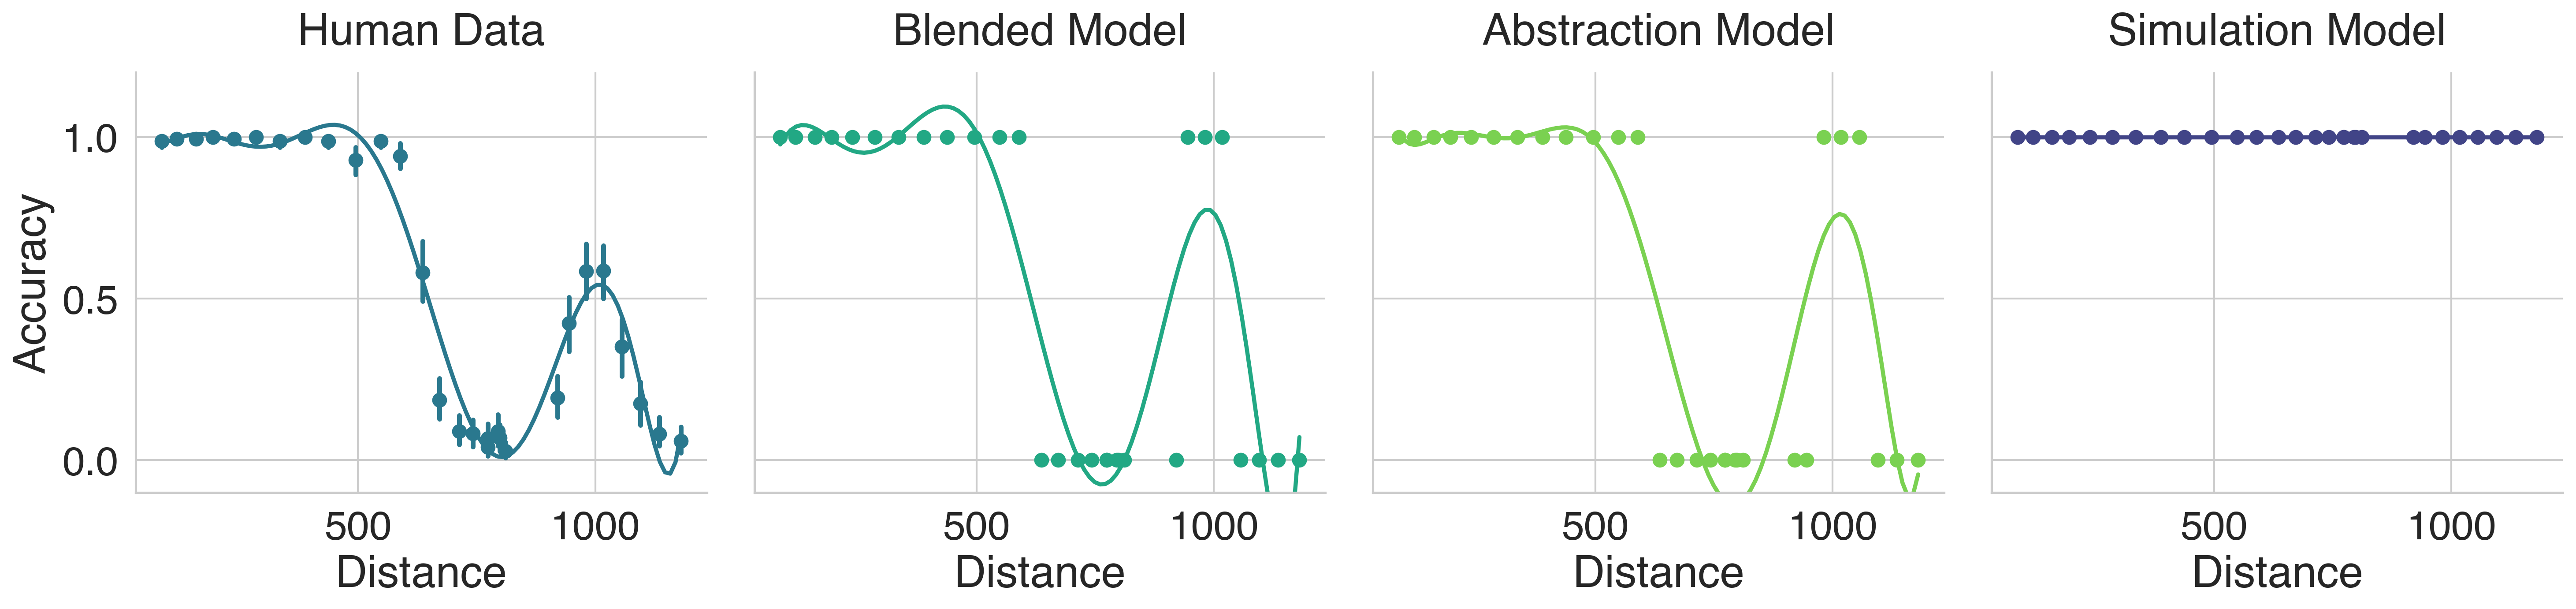

In [102]:
ax = sns.lmplot(
    data=accuracy_df[accuracy_df.scene_type =='1'],
    x="distance",
    y="correct",
    hue='model',
    order=8,
    col='model',
    col_order=[
        'empirical',
        'blended',
        'abstraction',
        'simulation',
    ],
    y_jitter=.01,
    palette='viridis',
    ci=None,
    x_ci=95,
    x_estimator=np.mean
)
ax.set(ylim=(-0.1,1.2))
axes = ax.axes.flatten()
axes[0].set_title('Human Data',pad=15)
axes[1].set_title('Blended Model', pad=15)
axes[2].set_title('Abstraction Model', pad=15)
axes[3].set_title('Simulation Model', pad=15)
ax.set_axis_labels(x_var='Distance', y_var='Accuracy')

if saving_figures:
    plt.savefig(f'{figure_dir}/exp2_results_panel.pdf')

In [103]:
empirical_acc = df_exp2[['correct','scene']]
empirical_acc['model'] = 'empirical'

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_55123/735060496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empirical_acc['model'] = 'empirical'


In [104]:
pivot_table = accuracy_df.pivot_table(index='scene', columns='model', values = 'correct', aggfunc='mean')

In [105]:
# Formula for empirical data to blended model
emp_simulation_formula = 'empirical ~ simulation'

# Ordinary linear models based on path condition for empirical data
simulation_model_predictions = smf.ols(
    emp_simulation_formula,
    pivot_table
).fit()

# Parameters from both models
intercept = simulation_model_predictions.params.Intercept
coefficient = simulation_model_predictions.params.simulation

pivot_table['simulation_fit'] = pivot_table.simulation.apply(lambda x: intercept + coefficient*x)

In [106]:
# Formula for empirical data to blended model
emp_simulation_formula = 'empirical ~ blended'

# Ordinary linear models based on path condition for empirical data
simulation_model_predictions = smf.ols(
    emp_simulation_formula,
    pivot_table
).fit()

# Parameters from both models
intercept = simulation_model_predictions.params.Intercept
coefficient = simulation_model_predictions.params.blended

pivot_table['blended_fit'] = pivot_table.blended.apply(lambda x: intercept + coefficient*x)

In [107]:
# Formula for empirical data to blended model
emp_simulation_formula = 'empirical ~ abstraction'

# Ordinary linear models based on path condition for empirical data
simulation_model_predictions = smf.ols(
    emp_simulation_formula,
    pivot_table
).fit()

# Parameters from both models
intercept = simulation_model_predictions.params.Intercept
coefficient = simulation_model_predictions.params.abstraction

pivot_table['simulation_fit'] = pivot_table.abstraction.apply(lambda x: intercept + coefficient*x)

In [108]:
num_observations = len(pivot_table)

In [109]:
mse_empirical_blended = np.mean((pivot_table['empirical'] - pivot_table['blended'])**2)
mse_empirical_simulation = np.mean((pivot_table['empirical'] - pivot_table['simulation'])**2)
mse_empirical_abstraction = np.mean((pivot_table['empirical'] - pivot_table['abstraction'])**2)

In [110]:
print(f'MSE of Blended Model predictions: {mse_empirical_blended}')
print(f'MSE of Abstraction Model predictions: {mse_empirical_abstraction}')
print(f'MSE of Simulation Model predictions: {mse_empirical_simulation}')

MSE of Blended Model predictions: 0.023163269360010317
MSE of Abstraction Model predictions: 0.025628987028345655
MSE of Simulation Model predictions: 0.19240134749926338


In [111]:
log_like_blended = -num_observations/2 * (np.log(2*np.pi * mse_empirical_blended) + 1)
log_like_simulation = -num_observations/2 * (np.log(2*np.pi * mse_empirical_simulation) + 1)
log_like_abstraction = -num_observations/2 * (np.log(2*np.pi * mse_empirical_abstraction) + 1)

In [112]:
print(f'Log-like of Blended Model predictions: {log_like_blended}')
print(f'Log-like of Abstraction Model predictions: {log_like_abstraction}')
print(f'Log-like of Simulation Model predictions: {log_like_simulation}')

Log-like of Blended Model predictions: 26.892001766873804
Log-like of Abstraction Model predictions: 23.95847168014949
Log-like of Simulation Model predictions: -34.501454548792715
